## **Image classification**


จากบทเรียนที่น้องๆได้ลองเรียนมานั้น จะเห็นว่า Deep learning สามารถนำไปใช้งานได้หลากหลายวิธีมากๆ หนึ่งในงานที่ใช้กันแพร่หลายมากคือ Image classification

โดยในบทเรียนแรกนี้เราจะมาลองทำ Image classification กันโดยใช้ library ตั้งแต่ FastAI, Pytorch และ Pytorch Ignite

โดย Dataset ที่เราจะเลือกใช้ในวันนี้จะใช้ชุดข้อมูลจาก Kaggle https://www.kaggle.com/c/dog-breed-identification

## Explore ชุดข้อมูล

- Download ชุดข้อมูล (ไปที่ Account มุมขวาบน > ใน section API กด "Create New API Token" > นำไปวางในโฟลเดอร์ `~/.kaggle/kaggle.json`)
- เตรียมชุดข้อมูลให้เหมาะสมกับการเทรนโมเดล (โค้ดตามด้านล่าง)

```
Downloaded format:
train/
test/
labels.csv

Preferred format:
- root_dir/train/
    breed1/
    breed2/
    breed3/
- root_dir/validation/
    breed1/
    breed2/
    breed3/
- root_dir/test/
    breed1/
    breed2/
    breed3/
```

In [1]:
# ! นำหน้าใน Notebook แปลว่าให้รันใน Terminal
!pip install kaggle torchvision fastbook

In [2]:
# !kaggle competitions download -c dog-breed-identification

In [3]:
# !unzip dog-breed-identification.zip -d data

In [4]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [5]:
# get all image paths
img_df = pd.DataFrame(glob("data/train/*.jpg"), columns=["path"])
img_df["id"] = img_df.path.map(lambda x: op.basename(x).replace(".jpg", ""))

# read label data
label_df = pd.read_csv("data/labels.csv")
train_df = img_df.merge(label_df, on="id")

In [6]:
print("Number of test images = ", len(glob("data/test/*.jpg")))

Number of test images =  10357


In [7]:
print("Number of train images = ", len(train_df))

Number of train images =  10222


In [8]:
train_df.head()

,path,id,breed
0,data/train/be7ae0578e96cd21c69b54b5252c1443.jpg,be7ae0578e96cd21c69b54b5252c1443,groenendael
1,data/train/f7c22e91e22c5a97abb2b7d9bab98809.jpg,f7c22e91e22c5a97abb2b7d9bab98809,african_hunting_dog
2,data/train/8a1b3f9f3ff9fef70962ac68704e629a.jpg,8a1b3f9f3ff9fef70962ac68704e629a,maltese_dog
3,data/train/59f13ba2b497debf4e6d2fbc9d1d2d5f.jpg,59f13ba2b497debf4e6d2fbc9d1d2d5f,brabancon_griffon
4,data/train/a0f900fe444c2c09f03d5170960e2825.jpg,a0f900fe444c2c09f03d5170960e2825,pug


In [9]:
root_dir = "data/train_breed"
for _, r in train_df.iterrows():
    if not op.exists(f"{root_dir}/{r.breed}"):
        os.makedirs(f"{root_dir}/{r.breed}")
    shutil.copy(r.path, f"{root_dir}/{r.breed}/{r.id}.jpg")

## Image classification ด้วย FastAI

- `blocks` ใช้สำหรับใส่คู่ระหว่าง input และ output ในที่นี้คือ `ImageBlock`, `CategoryBlock`
- เราจะใช้ `get_items` ในการดึงภาพออกมาจากโฟลเดอร์ โดย `get_image_files` เป็นฟังก์ชันของ FastAI ที่ใช้หา path สำหรับโฟลเดอร์ที่กำหนด
- โดยเราจะใช้ `get_y` ในการหาว่า `label` ของแต่ละภาพคืออะไร ในที่นี้คือใช้ฟังก์ชัน `parent_label` ของ FastAI เช่นกัน
- รูปแบบของการวางโฟลเดอร์เป็นดังนี้ `<grant_parent>/<parent>/<img.jpg>`
- `item_tfms` เป็นการ transform ภาพก่อนที่จะส่งไปยัง GPU ในที่นี่เราจะทำการย่อภาพก่อนที่จะส่งไปยัง GPU
- `batch_tfms` เป็นการ transform ภาพใน GPU ในที่นี้เราจะใช้ `aug_transforms` ซึ่งเป็นฟังก์ชันของ FastAI ในการทำให้ภาพมีความหลากหลายมากยิ่งขึ้น

In [10]:
# สำหรับคนที่ยังไม่ได้ลงไลบรารี่ fastbook ให้ uncomment บรรทัด !pip install
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [11]:
from fastbook import *

In [12]:
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # GrandparentSplitter(valid_name='validation')
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

In [13]:
get_image_files("data/test/")

(#10357) [Path('data/test/d4375afc01dbc1d0737e4b5601ba8297.jpg'),Path('data/test/8bdc1bb017b6d13f87819804504953b3.jpg'),Path('data/test/2bfb83abc7b3b67fe15d12d6106895cf.jpg'),Path('data/test/8919c1920ba56b25c91d806765446b39.jpg'),Path('data/test/c4b157b662d565936af2ad8e6bcfa08e.jpg'),Path('data/test/ac347274ae8bd8e185435069d4af3697.jpg'),Path('data/test/68f1c5a8a18ef3b060514a6de813fa98.jpg'),Path('data/test/d053ae3e36f5b2e48dae4b484f313c7e.jpg'),Path('data/test/015a6a8a46302983fad0e5ea258b351a.jpg'),Path('data/test/56552ac2cffbe9d68f0a304459d665a5.jpg'),Path('data/test/6f4614643a12fed5b067173d8d4972fc.jpg'),Path('data/test/114a4a1fe266429ccb8ae42b5f8556cf.jpg'),Path('data/test/6beb8885683ffcb36e53ad8281924807.jpg'),Path('data/test/f47cd43251c741ee459c688955c41f29.jpg'),Path('data/test/e6ed62f411426a4f7e26e6ccdbaf7ecc.jpg'),Path('data/test/5e8a978ab8ab47bfb3ff4dd6f41a2f54.jpg'),Path('data/test/74fa841a3e1aecfff900c3d7a6673cdb.jpg'),Path('data/test/9ec769e34bc902bd9de458103e9347c8.jpg'),

In [14]:
parent_label("data/test/000621fb3cbb32d8935728e48679680e.jpg")

'test'

In [15]:
dls = fields.dataloaders("data/train_breed/",bs = 16)

In [16]:
dls.vocab

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

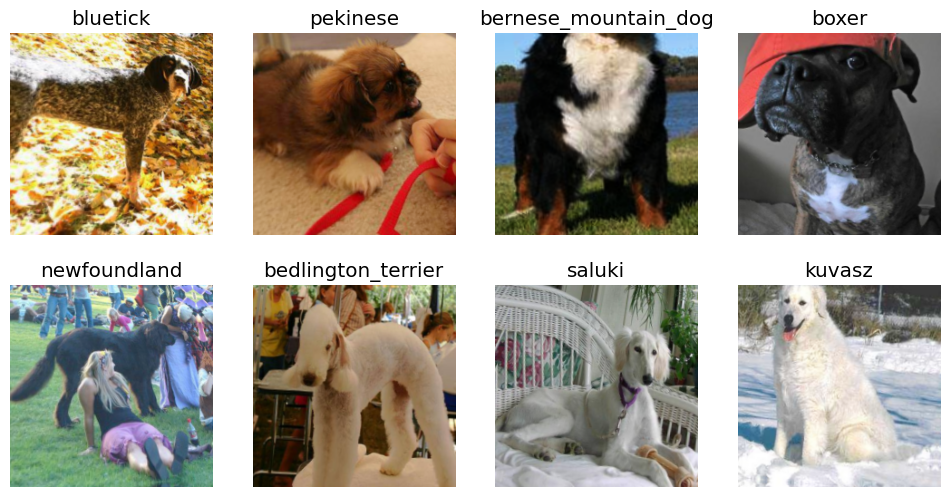

In [17]:
dls.train.show_batch(max_n=8, nrows=2)

In [18]:
learner = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy]).to_fp16()

/home/drasogun/.venvs/vol3/lib/python3.13/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.004365158267319202)

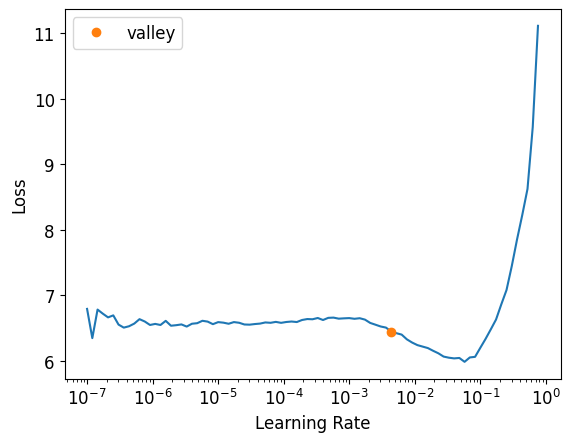

In [19]:
learner.lr_find() # หา learning rate ที่เหมาะสม

In [20]:
learner.fine_tune(epochs=6, freeze_epochs=1, base_lr=0.0012)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.350679,1.317007,0.386497,0.613503,00:28


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.634415,1.029518,0.309198,0.690802,00:35
1,1.589957,1.014897,0.304795,0.695205,00:34
2,1.322981,0.956895,0.277887,0.722113,00:35
3,1.058859,0.924592,0.261252,0.738748,00:35
4,0.856421,0.901548,0.261252,0.738748,00:35
5,0.757185,0.847230,0.255871,0.744129,00:35


## **ทำนายผล**

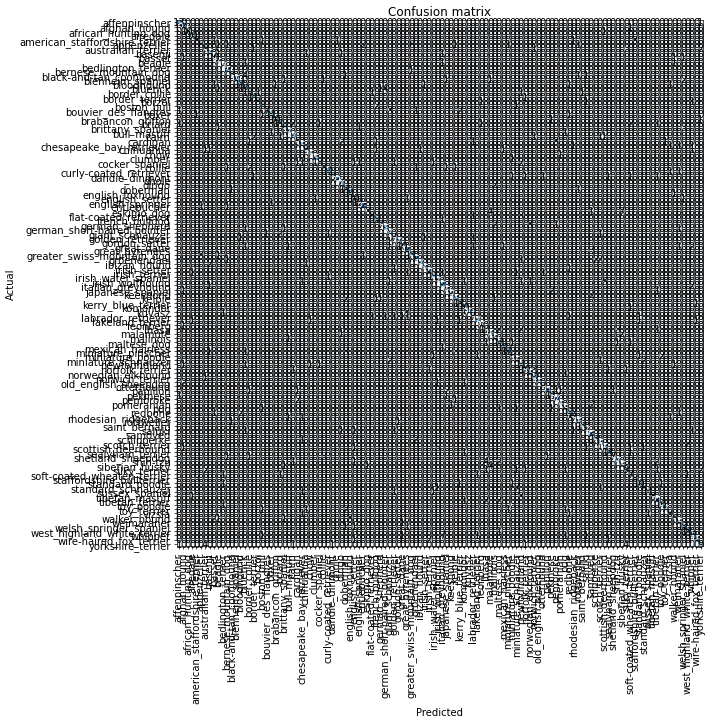

In [21]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
interp.most_confused(min_val=5)

[('eskimo_dog', 'siberian_husky', np.int64(7)),
 ('standard_schnauzer', 'miniature_schnauzer', np.int64(7)),
 ('whippet', 'italian_greyhound', np.int64(7)),
 ('appenzeller', 'greater_swiss_mountain_dog', np.int64(6)),
 ('border_collie', 'collie', np.int64(6)),
 ('irish_wolfhound', 'scottish_deerhound', np.int64(5)),
 ('scottish_deerhound', 'irish_wolfhound', np.int64(5))]

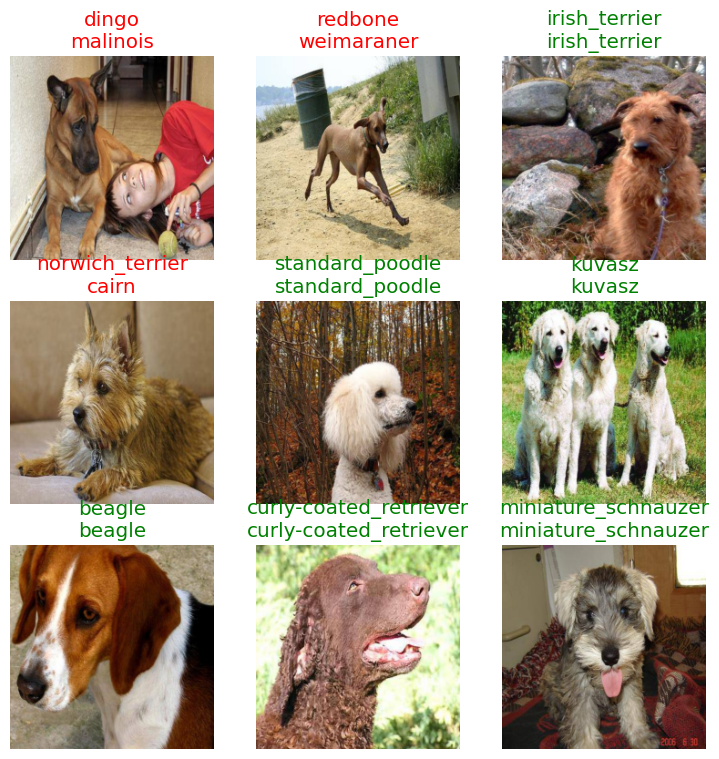

In [23]:
learner.show_results(shuffle=True)

## **เซฟโมเดล**

In [24]:
learner.export("dbc_resnet34_fastai.pkl")

## **โหลดโมเดลเพื่อทำนายผล**

In [25]:
from fastbook import *
from glob import glob
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

learn_inf = load_learner('dbc_resnet34_fastai.pkl')

/home/drasogun/.venvs/vol3/lib/python3.13/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


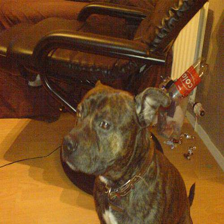

In [26]:
Image.open("data/test/0953e8a5ff606ad468a9113317627652.jpg").resize((224, 224))

In [27]:
learn_inf.predict("data/test/0953e8a5ff606ad468a9113317627652.jpg")

('staffordshire_bullterrier',
 tensor(104),
 tensor([4.9729e-05, 1.1888e-05, 2.3389e-04, 9.6875e-05, 1.4526e-01, 6.8555e-05, 2.6328e-05, 9.8896e-04, 1.2803e-04, 3.9681e-05, 1.3658e-04, 5.7309e-06, 1.1874e-04, 2.1808e-05, 7.2635e-04, 2.1673e-04,
         3.7164e-05, 1.3651e-03, 6.0403e-06, 8.2445e-05, 1.3121e-04, 2.2839e-01, 1.2622e-03, 1.5442e-05, 9.6153e-06, 3.7547e-03, 7.4916e-05, 3.3774e-04, 9.3864e-04, 1.4754e-04, 5.1064e-04, 3.5219e-05,
         5.2016e-05, 1.9433e-06, 1.0890e-03, 6.3278e-06, 1.2418e-02, 9.5743e-04, 3.5136e-04, 1.7955e-05, 1.8313e-05, 7.6955e-06, 4.1406e-05, 2.4228e-05, 1.0511e-05, 6.5213e-03, 3.0394e-05, 2.2081e-04,
         1.2872e-04, 1.0525e-05, 8.5743e-05, 1.9795e-03, 3.6504e-05, 4.7998e-05, 4.7432e-05, 7.8001e-05, 7.9697e-05, 9.4123e-04, 6.7690e-04, 6.1440e-05, 9.8913e-04, 1.9300e-05, 8.7257e-05, 4.2064e-04,
         4.2955e-04, 2.6046e-05, 2.4663e-05, 1.1409e-03, 1.0123e-04, 3.5449e-04, 4.9421e-05, 1.3202e-05, 3.6301e-03, 4.4193e-05, 7.9487e-04, 1.2566e-03,